In [102]:
# Import dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [103]:
# Get data
transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

data_loader = DataLoader(mnist_data, batch_size=64, shuffle=True)

In [104]:
# Analyze data
dataiter = iter(data_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

latent_dims = 2

tensor(0.) tensor(1.)


In [105]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512).to(DEVICE)
        self.linear2 = nn.Linear(512, latent_dims).to(DEVICE)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

In [106]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512).to(DEVICE)
        self.linear2 = nn.Linear(512, 784).to(DEVICE)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

In [107]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512).to(DEVICE)
        self.linear2 = nn.Linear(512, latent_dims).to(DEVICE)
        self.linear3 = nn.Linear(512, latent_dims).to(DEVICE)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc#.cuda() # hack to get sampling on the GPU -> can't access it on MacBook
        self.N.scale = self.N.scale#.cuda()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = nn.functional.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [108]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [109]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [110]:
# Instantiate neural net and optimizer
vae = VariationalAutoencoder(latent_dims)
optimizer = optim.Adam(vae.parameters())#, lr=1e-3, weight_decay=1e-5)

num_epochs = 10

In [111]:
# Train the Autoencoder
def train(autoencoder, optimizer, data_loader, num_epochs=10):
    outputs = []
    
    for epoch in range(num_epochs):
        for img, _ in data_loader:
            recon = autoencoder(img)
            loss = ((img - recon)**2).sum() + autoencoder.encoder.kl

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch:{epoch+1}, Loss:{loss.item():.4f}")
        outputs.append((epoch, img, recon))
    return outputs, autoencoder

In [112]:
outputs, autoencoder = train(vae, optimizer, data_loader, num_epochs)

Epoch:1, Loss:1324.5477
Epoch:2, Loss:1318.2220
Epoch:3, Loss:1286.8914
Epoch:4, Loss:1279.9749
Epoch:5, Loss:1295.3523
Epoch:6, Loss:1185.2621
Epoch:7, Loss:1385.4816
Epoch:8, Loss:1243.1304
Epoch:9, Loss:1383.1710
Epoch:10, Loss:1319.5582


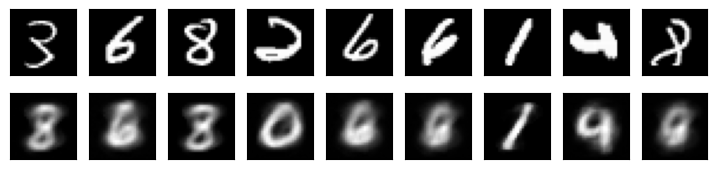

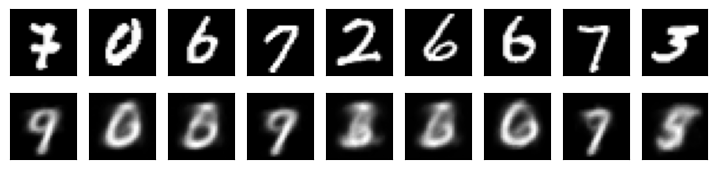

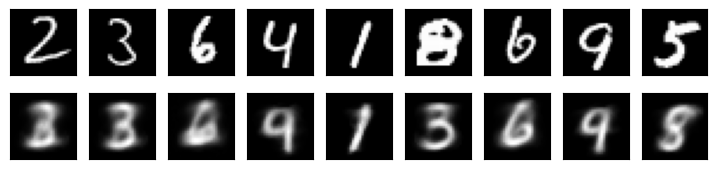

In [113]:
# Plot the reconstructed images
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()

    for i, item in enumerate(imgs):
        if i >= 9: break

        plt.subplot(2, 9, i+1)
        plt.tick_params(left = False, 
                        right = False,
                        labelleft = False,
                        labelbottom = False,
                        bottom = False
                        )
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.tick_params(left = False, 
                        right = False,
                        labelleft = False,
                        labelbottom = False,
                        bottom = False
                        )
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])

In [114]:
def plot_latent(autoencoder, data_loader, num_batches=100):
    for i, (img, label) in enumerate(data_loader):
        # img = img.reshape(-1, 28*28)
        z = autoencoder.encoder(img.to(DEVICE))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=label, cmap='tab10', marker=".")
        if i > num_batches:
            plt.colorbar()
            break

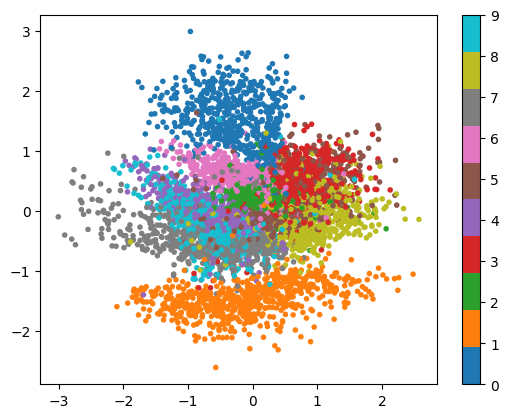

In [115]:
plot_latent(autoencoder, data_loader)

In [116]:
import numpy as np
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    width = 28
    img = np.zeros((n*width, n*width))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(DEVICE)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to(DEVICE).detach().numpy()
            img[(n-1-i)*width:(n-1-i+1)*width, j*width:(j+1)*width] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

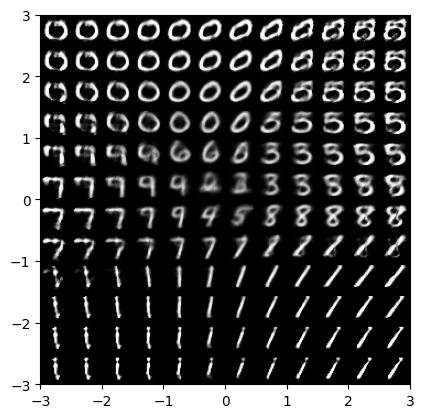

In [117]:
plot_reconstructed(autoencoder, r0=(-3, 3), r1=(-3, 3))